```project.ipynb```

# Finding Modulation Transfer Function Curve of the James Webb Space Telescope

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage, signal
import scipy.special as scifunc
import scipy.misc as scimisc

from astropy.io import fits

## Airy Disk Functions

In [2]:
def airy(r):
    wavelength = 550e-9 #m
    distance   = 5 #m
    aperture   = 5 #m
    
    k = 2 * np.pi / wavelength
    d = distance
    a = aperture
    
    u = k * a * r / (d**2 + r**2)
    return np.nan_to_num((2 / u * scifunc.jn(1,u))**2,nan=1)

def rSquare(a,b,n):
    '''Returns a square of radii from the origin for a square 
    with sides going from a to b with n n points to a side'''
    xy   = np.linspace(a,b,n)
    x,y  = np.meshgrid(xy,xy)
    return np.sqrt(x**2 + y**2)

<ipython-input-2-3e42eadc6e8f>:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num((2 / u * scifunc.jn(1,u))**2,nan=1)


<ipython-input-2-3e42eadc6e8f>:11: RuntimeWarning: invalid value encountered in multiply
  return np.nan_to_num((2 / u * scifunc.jn(1,u))**2,nan=1)


Text(0.5, 1.0, '1D Airy Disk')

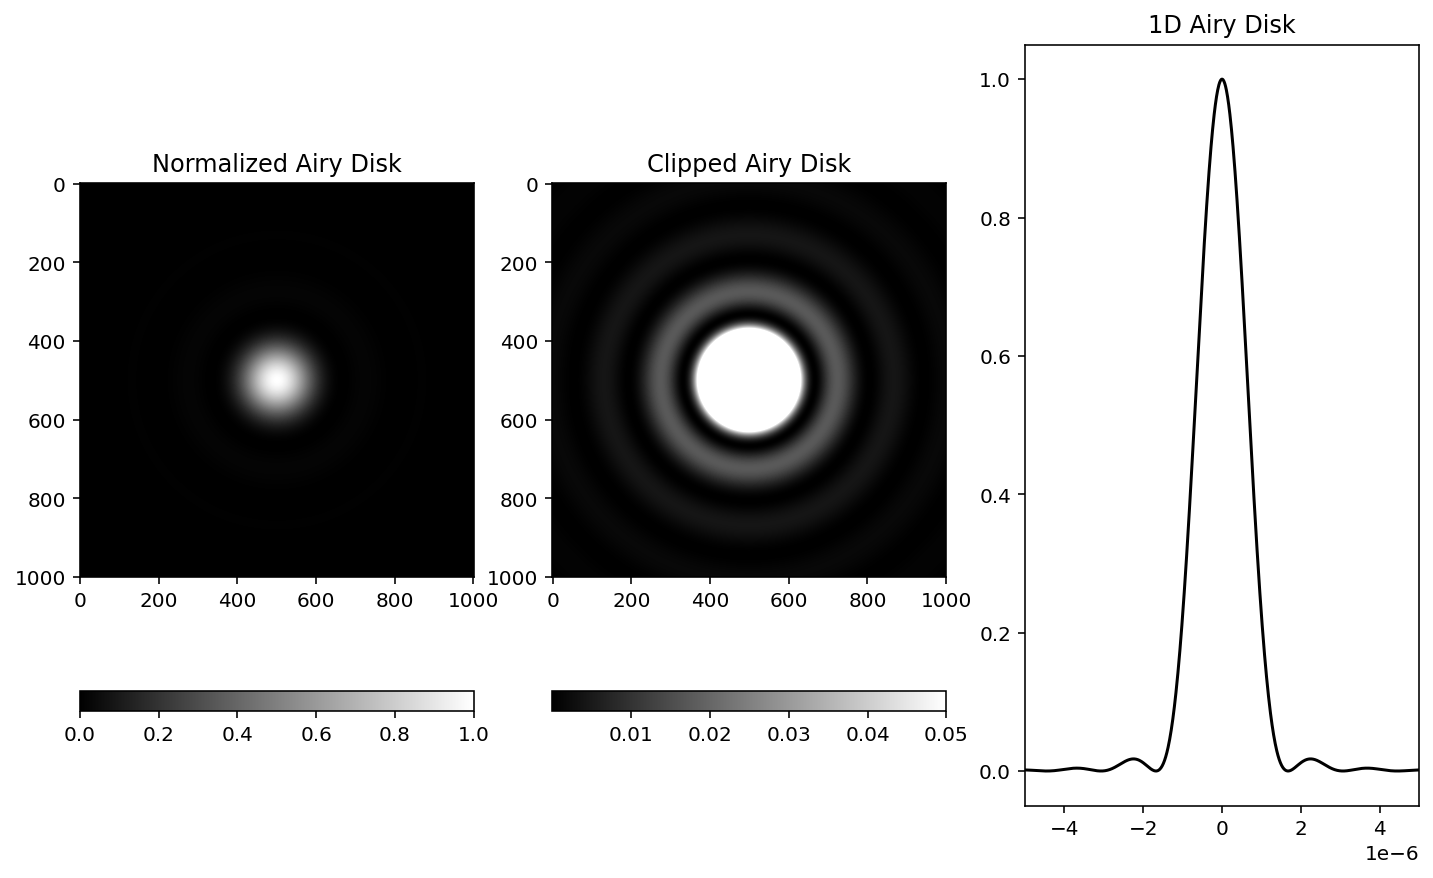

In [3]:
lrlim = 5e-6 #m #Left-Right Limit
x  = np.linspace(-lrlim,lrlim,1001)
adisk = airy(rSquare(-lrlim,lrlim,1001))

fig,ax = plt.subplots(1,3)
normed  = ax[0].imshow(adisk,cmap=plt.cm.gray)
clipped = ax[1].imshow(adisk,vmax=0.05,cmap=plt.cm.gray)
fig.colorbar(normed, ax=ax[0],orientation='horizontal')
fig.colorbar(clipped,ax=ax[1],orientation='horizontal')
ax[2].plot(x,airy(x),'k')
ax[2].set_xlim(-lrlim,lrlim)
ax[0].set_title("Normalized Airy Disk")
ax[1].set_title("Clipped Airy Disk")
ax[2].set_title("1D Airy Disk")

## Convolution Functions

In [4]:
def normalize(image,normal=1):
    '''Normaizes a positive function to go from 0 to normal (default 1)
    '''
    image -= np.min(image)
    image /= np.max(image)
    return image * normal

def invertPSF(pattern):
    '''Returns the inverse point spread function, 
    which can be used as the convolution kernel in scipy.ndimage.convolve
    Does so by rotating the pattern 180 degrees
    '''
    return np.rot90(pattern,2)

def convolveSignal(image,kernel,overcrop = False):
    '''Applies the PSF to an image using scipy.signal.convolve
    '''
    x,y = np.shape(kernel)
    if not overcrop:
        x //= 2
        y //= 2
    return signal.convolve(image,kernel)[x:-x,y:-y]

def convolveLoop(image,pattern):
    '''Applies the PSF to an image using a loop
    It will likely do a better job of simulating star views than scipy.ndimage.convolve
    '''
    x, y  = np.shape(image)
    xp,yp = np.shape(pattern)
    dx,dy = int(np.ceil(xp/2)),int(np.ceil(yp/2))
    newimage = np.zeros((x+xp+1,y+yp+1))
    for i in range(x):
        for j in range(y):
            newimage[i:i+xp,j:j+yp] += image[i,j] * pattern
    return newimage[dx:dx+x,dy:dy+y]

In [5]:
circle = (rSquare(-1,1,5) < 1).astype(int)
square = np.ones((1,1))

image = scimisc.face(gray=True)
print("image  ",type(image),np.shape(image))

pattern = airy(rSquare(-5e-6,5e-6,100))
print("pattern",type(pattern),np.shape(pattern))

signalC = convolveSignal(image,invertPSF(pattern))
print("signalC",type(signalC),np.shape(signalC))

loopC = convolveLoop(image,pattern)
print("loopC",type(loopC),np.shape(loopC))

image   <class 'numpy.ndarray'> (768, 1024)
pattern <class 'numpy.ndarray'> (100, 100)
signalC <class 'numpy.ndarray'> (767, 1023)


loopC <class 'numpy.ndarray'> (768, 1024)


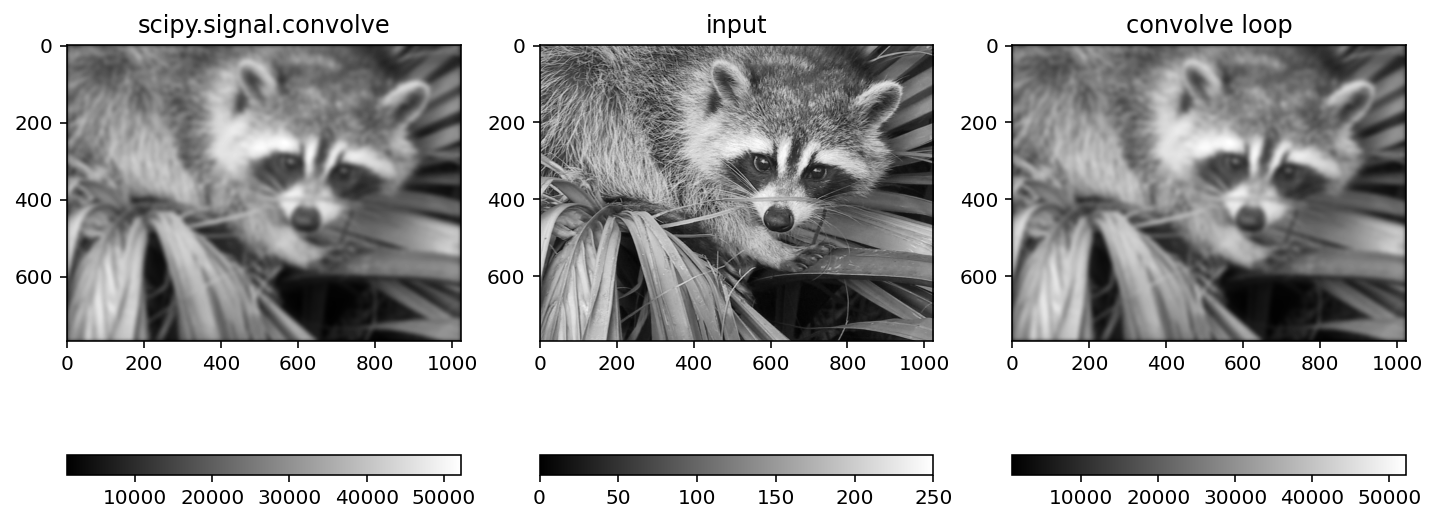

In [6]:
fig,ax = plt.subplots(1,3)
im = []

ax[0].set_title("scipy.signal.convolve")
im.append(ax[0].imshow(signalC,cmap=plt.cm.gray))
fig.colorbar(im[0],ax=ax[0],orientation='horizontal')

ax[1].set_title("input")
im.append(ax[1].imshow(image,cmap=plt.cm.gray))
fig.colorbar(im[1],ax=ax[1],orientation='horizontal')

ax[2].set_title("convolve loop")
im.append(ax[2].imshow(loopC,cmap=plt.cm.gray))
fig.colorbar(im[2],ax=ax[2],orientation='horizontal')

## MTF Sample Rulings

In [7]:
def xtall(x, y):
    X,Y = np.meshgrid(np.arange(x),np.arange(y))
    return X * 2 * np.pi

def xrot(x, y, theta):
    X,Y = np.meshgrid(np.arange(x),np.arange(y))
    Xr  =  np.cos(theta/180*np.pi)*X - np.sin(theta/180*np.pi)*Y
    return Xr * 2 * np.pi

def ronchi(X, wavelength, duty = 0.5):
    return signal.square(X / wavelength, duty) / 2 + 0.5

def ronchif(X, frequency, duty = 0.5):
    return signal.square(X * frequency, duty) / 2 + 0.5

def sinerule(X, wavelength):
    return np.sin(X / wavelength) / 2 + 0.5

def sinerulef(X, frequency):
    return np.sin(X * frequency) / 2 + 0.5

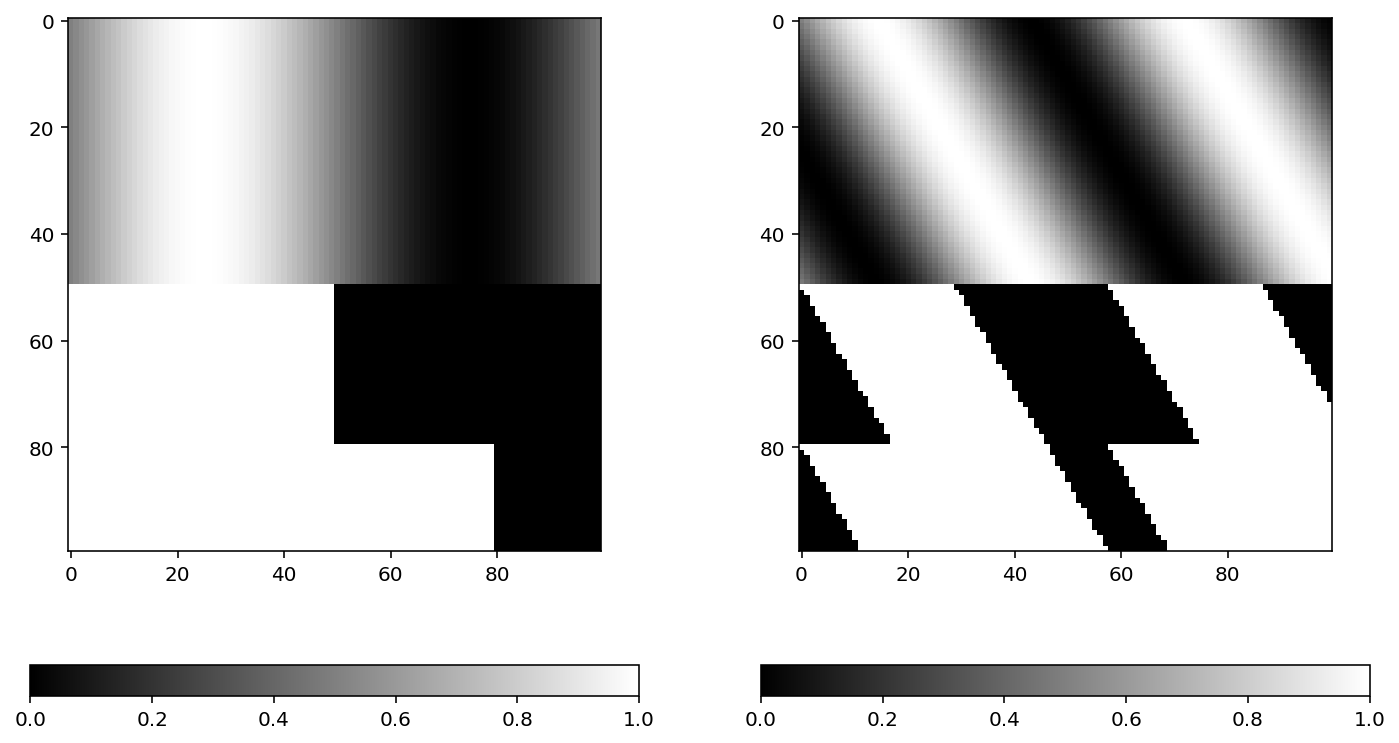

In [8]:
gradient = np.concatenate((sinerule(xtall(100,50),100),
                           ronchi(xtall(100,30),100),
                           ronchi(xtall(100,20),100,0.8)),axis=0)
gradientR = np.concatenate((sinerule(xrot(100,50,30),50),
                           ronchi(xrot(100,30,30),50),
                           ronchi(xrot(100,20,30),50,0.8)),axis=0)

plt.subplot(121)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.colorbar(orientation='horizontal')
plt.subplot(122)
plt.imshow(gradientR,cmap=plt.cm.gray)
plt.colorbar(orientation='horizontal')

## MTF Function

In [9]:
def contrast(image, cropx=0, cropy=0):
    cropx,cropy = int(cropx),int(cropy)
    cropped = image[cropx:-cropx,cropy:-cropy]
    maxi = np.max(cropped)
    mini = np.min(cropped)
    return (maxi-mini) / (maxi+mini)

def mtf(psf, frequencies, rotation = None):
    kernel = invertPSF(psf)
    minfreq = np.min(frequencies)
    xp,yp = np.shape(psf)
    cropx,cropy = int(2*xp),int(2*yp)
    h,w = int(2/minfreq+2*cropx),int(2/minfreq+2*cropy)
    if rotation == None:
        X = xtall(w,h)
    else:
        X = xrot(w,h,rotation)
    contrasts = np.zeros(np.shape(frequencies))
    for i,freq in enumerate(frequencies):
        contrasts[i] = contrast(convolveSignal(sinerulef(X,freq),kernel),cropx,cropy)
    risk = frequencies > 0.5
    if np.any(risk):
        print("Risk of aliasing at the following frequencies:")
        print(frequencies[risk])
    return normalize(contrasts)

def mtfWave(psf, wavelengths, rotation = None):
    kernel = invertPSF(psf)
    maxwave = np.max(wavelengths)
    xp,yp = np.shape(psf)
    cropx,cropy = int(2*xp),int(2*yp)
    h,w = int(2*maxwave+2*cropx),int(2*maxwave+2*cropy)
    if rotation == None:
        X = xtall(w,h)
    else:
        X = xrot(w,h,rotation)
    contrasts = np.zeros(np.shape(wavelengths))
    for i,wavelength in enumerate(wavelengths):
        contrasts[i] = contrast(convolveSignal(sinerule(X,wavelength),kernel),cropx,cropy)
    risk = wavelengths < 2
    if np.any(risk):
        print("Risk of aliasing at the following wavelengths:")
        print(wavelengths[risk])
    return normalize(contrasts)

In [10]:
psf = airy(rSquare(-5e-6,5e-6,100))

frequencies = np.geomspace(1e-3,0.5,50)
wavelengths = 1 / frequencies

contrastsw = mtfWave(psf,wavelengths)
contrastsf = mtf(psf,frequencies)

In [11]:
frequenciesl = np.linspace(0,0.5,101)[1:]
wavelengthsl = 1 / frequencies

contrastswl = mtfWave(psf,wavelengths)
contrastsfl = mtf(psf,frequencies)

Text(0, 0.5, 'Contrast')

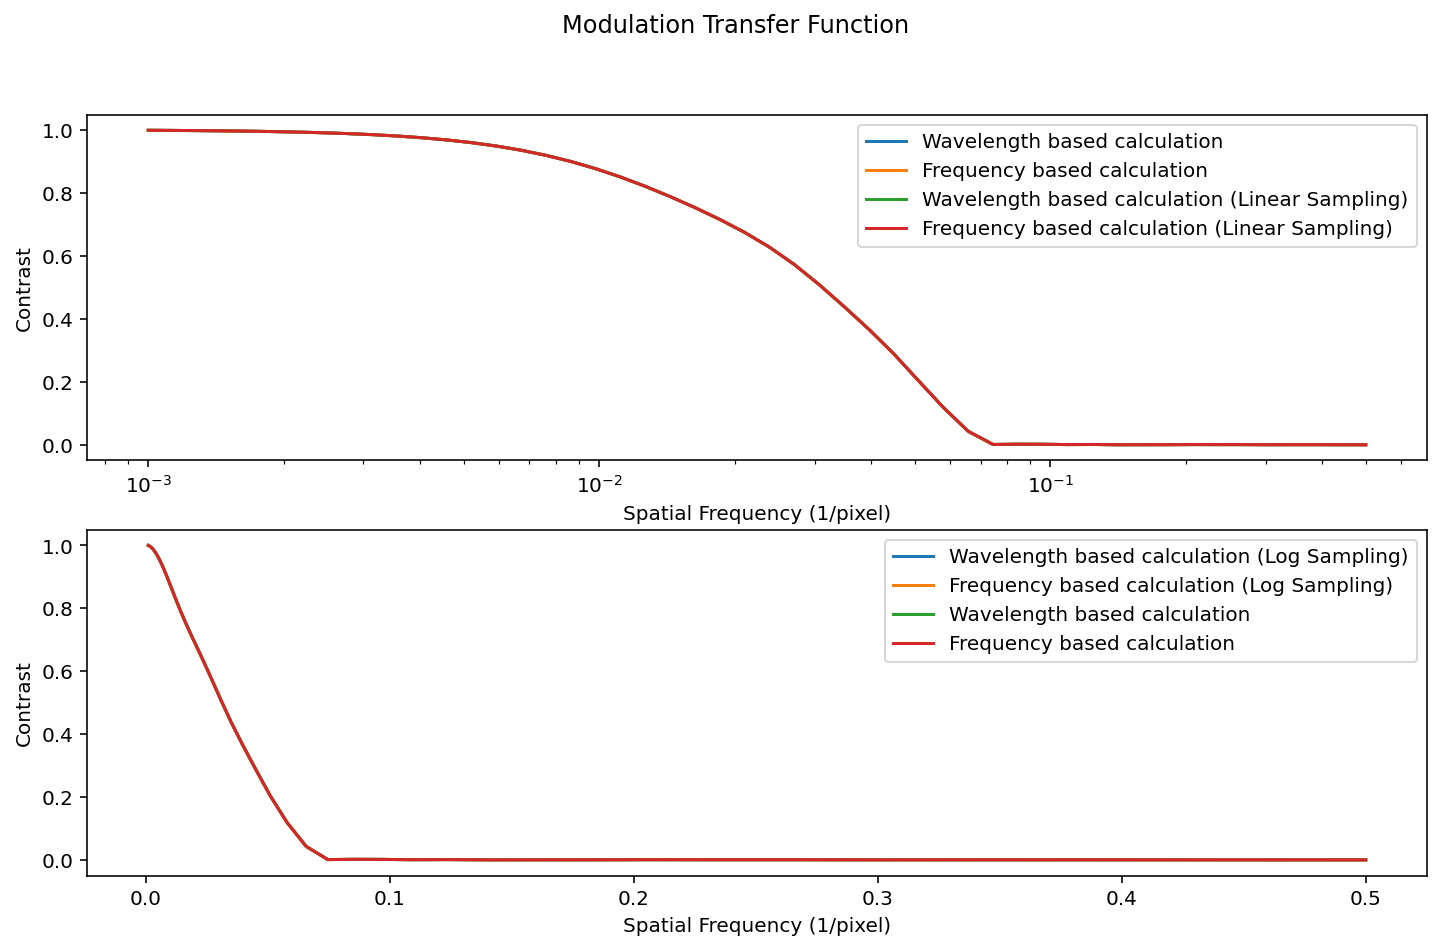

In [12]:
plt.suptitle("Modulation Transfer Function")

plt.subplot(211)
plt.semilogx(frequencies,contrastsw,label="Wavelength based calculation")
plt.semilogx(frequencies,contrastsf,label="Frequency based calculation")
plt.semilogx(frequencies,contrastswl,label="Wavelength based calculation (Linear Sampling)")
plt.semilogx(frequencies,contrastsfl,label="Frequency based calculation (Linear Sampling)")
plt.legend()
plt.xlabel("Spatial Frequency (1/pixel)")
plt.ylabel("Contrast")

plt.subplot(212)
plt.plot(frequencies,contrastsw,label="Wavelength based calculation (Log Sampling)")
plt.plot(frequencies,contrastsf,label="Frequency based calculation (Log Sampling)")
plt.plot(frequencies,contrastswl,label="Wavelength based calculation")
plt.plot(frequencies,contrastsfl,label="Frequency based calculation")
plt.legend()
plt.xlabel("Spatial Frequency (1/pixel)")
plt.ylabel("Contrast")

## JWST NIRCam PSF

In [13]:
# import image and read table
images = fits.open('data/PSF_NIRCam_predicted_opd_filter_F470N.fits')
images.info()

Filename: data/PSF_NIRCam_predicted_opd_filter_F470N.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      95   (636, 636)   float64   
  1  DET_SAMP      1 ImageHDU        97   (159, 159)   float64   
  2  OVERDIST      1 ImageHDU       141   (636, 636)   float64   
  3  DET_DIST      1 ImageHDU       142   (159, 159)   float64   


In [14]:
# Import needed oversampled image, crop, normalize
image = images[0].data
images.close()
print(type(image))
print(np.shape(image))

<class 'numpy.ndarray'>
(636, 636)


(100, 100)


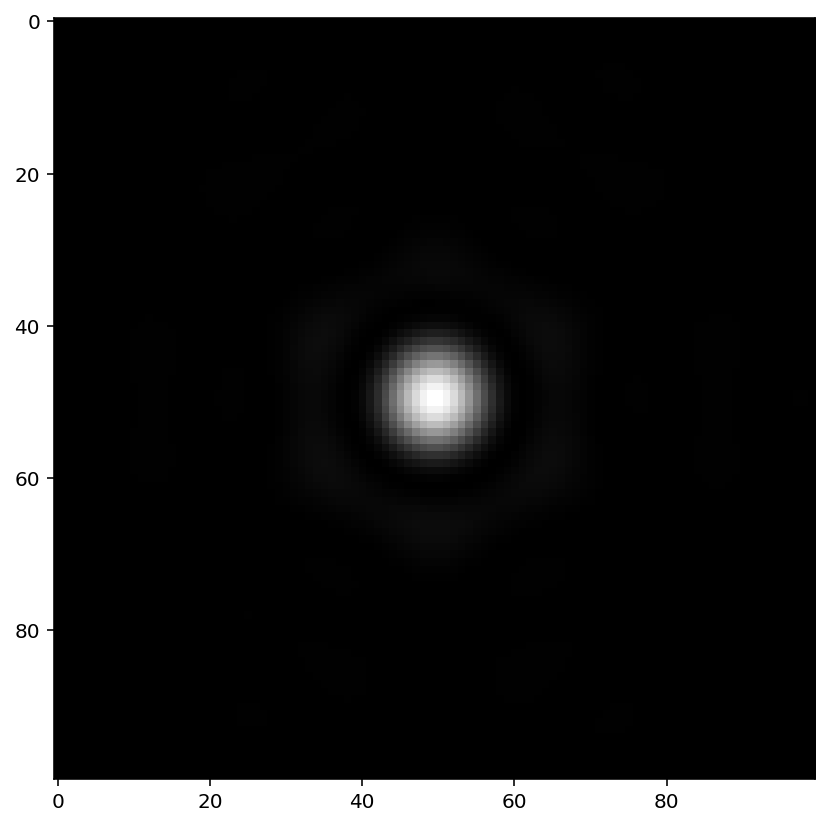

In [15]:
# Crop, normalize, save
x0,y0 = np.shape(image)
xf,yf = 100,100
cropped = image[x0//2-xf//2:x0//2+xf//2,y0//2-yf//2:y0//2+yf//2]
psf = normalize(cropped)
print(np.shape(psf))

plt.imshow(psf, cmap='gray')
#plt.colorbar()

plt.savefig('images/psf.png')

## JWST NIRCam MTF

In [16]:
conversion = 1 / 0.07 * 4 # arcseconds (4x oversampling)
frequencies = np.linspace(7e-4,0.5,50)
flabels = frequencies * conversion
contrasts = mtf(psf,frequencies)

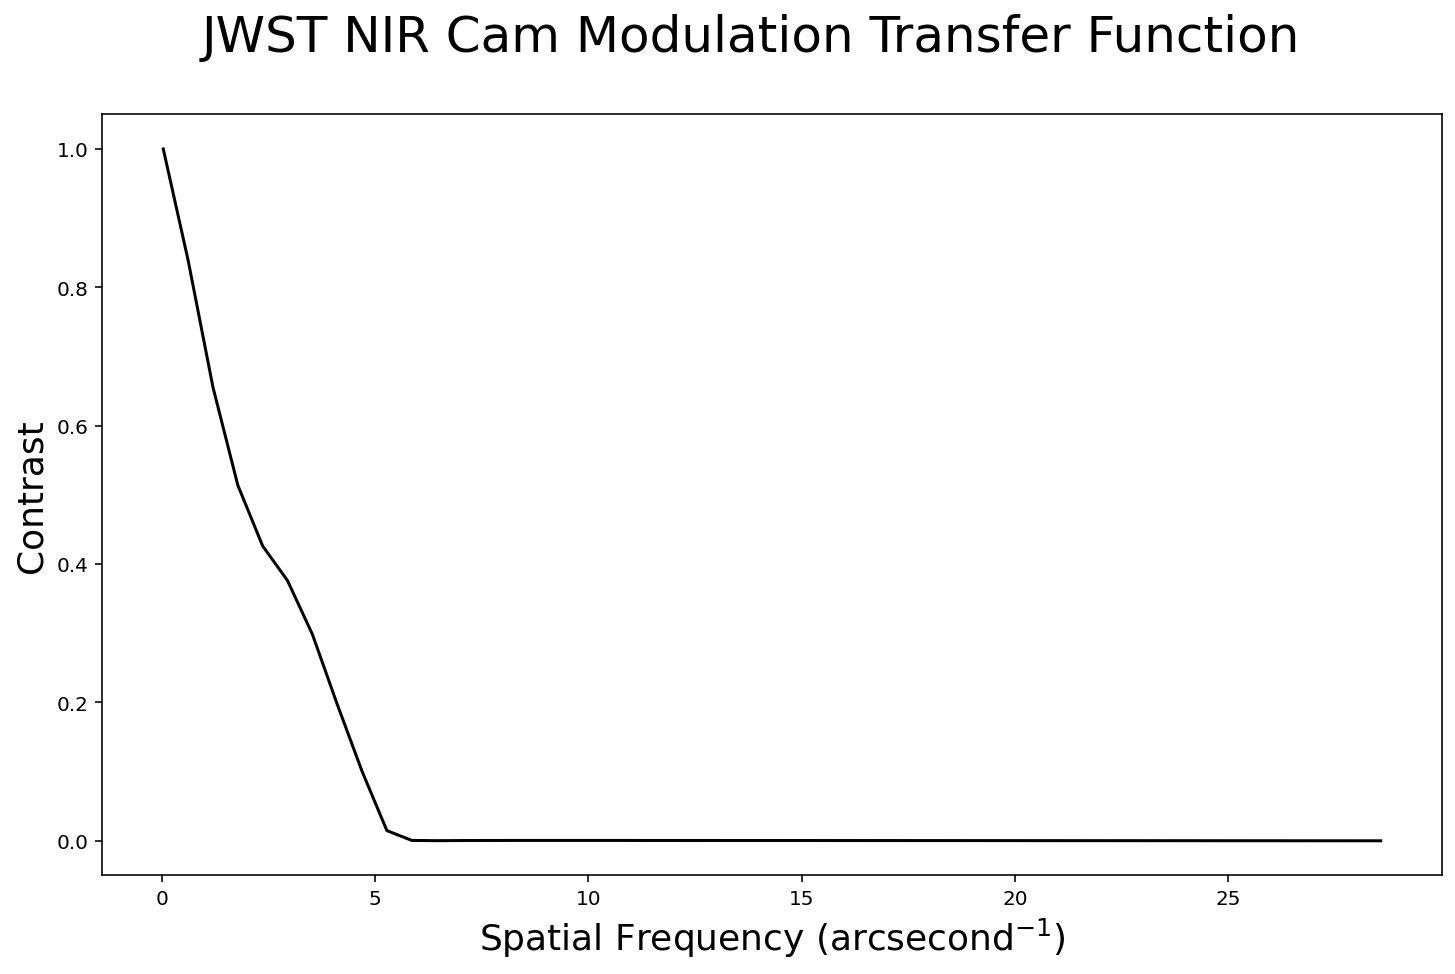

In [17]:
plt.suptitle("JWST NIR Cam Modulation Transfer Function",fontsize=25)

plt.plot(flabels,contrasts,'k',label="Wavelength based calculation")
plt.xlabel("Spatial Frequency (arcsecond${}^{-1}$)",fontsize=18)
plt.ylabel("Contrast",fontsize=18)

plt.savefig('images/mtf.png')

## Figures

In [0]:
# Will separate out in future verion if applicable